In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import albumentations as A

from skimage import exposure
import os
import pydicom
import torch
from pathlib import Path
from torchvision import transforms
import sys
import matplotlib.pyplot as plt

from skimage import exposure

import time
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cpu')

In [3]:
#load image npy
image_1=np.load(f"C:/AI/Datasets/Part 1/Images/images.npy",mmap_mode='r')[:1000]
masks_1=np.load(f"C:/AI/Datasets/Part 1/Masks/masks.npy",mmap_mode='r')[:1000]

# delete pairs with no cells
index = [584, 586, 604, 748, 750, 780, 811, 812, 813, 828, 830, 832, 833,
         996, 998, 1147, 1148, 1149, 1152, 1155, 1158, 1160, 1161, 1164,
         1166, 1432, 1433, 1512, 1578, 1614, 1615, 1616, 1617, 1618, 1619,
         1620, 1629, 1632, 1704, 1705, 1707, 1708, 1709, 1723, 1724, 1725,
         1748, 1749, 1750, 1751, 1752, 1753, 1859, 1864, 1870, 1880, 1923,
         1939, 1940, 1945, 1946, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
         1973, 1974, 1975, 1976, 1977, 1978, 1979, 2007, 2009, 2019, 2020,
         2022, 2098, 2108, 2109, 2110, 2111, 2115, 2131, 2132, 2133, 2134,
         2135, 2137, 2163, 2164, 2165, 2174, 2176, 2202, 2263, 2264, 2265,
         2267, 2406, 2407, 2462, 2463, 2464, 2465, 2515, 2550, 2551, 2552,
         2626, 2636, 2639, 2640]  
index = [584, 586, 604, 748, 750, 780, 811, 812, 813, 828, 830, 832, 833,
         996, 998]  
image_1 = np.delete(image_1, index, 0)
masks_1 = np.delete(masks_1, index, 0)

In [4]:
#print shape of image npy
print(image_1.shape)
print(masks_1.shape)

(985, 256, 256, 3)
(985, 256, 256, 6)


In [5]:
#Change the dtype to int to show the image
image_1_32=image_1.astype('int32')
masks_1_32=masks_1.astype('int32')

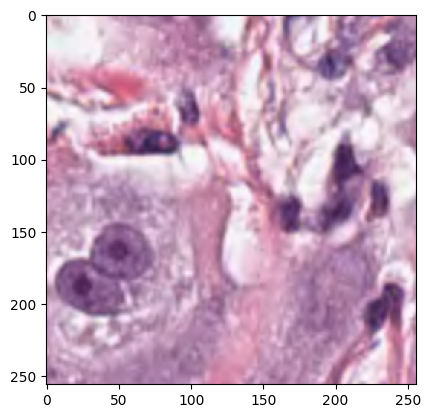

In [6]:
# example image
plt.imshow(image_1_32[0])

In [7]:
def enhance_image(image):
    """
    Enhances a single image using edge enhancement with Gaussian method and contrast enhancement.

    Args:
    image (numpy array): The input image in numpy array format.

    Returns:
    numpy array: The enhanced image.
    """
    # Edge enhancement using Gaussian method
    # Creating a Gaussian kernel
    gaussian_kernel = cv2.getGaussianKernel(ksize=5, sigma=0)
    # Applying the kernel to the image
    enhanced_image = cv2.filter2D(src=image, ddepth=-1, kernel=gaussian_kernel)

    # Enhance contrast
    # Converting to float as exposure.equalize_adapthist requires floating point images
    enhanced_image = enhanced_image.astype('float32') / 255
    # Adaptive histogram equalization
    enhanced_image = exposure.equalize_adapthist(enhanced_image)

    return enhanced_image


def process_guassian_K(img_array):
    # Read the DICOM file
    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)
    # Convert to color image
    color_img = img_array#cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

    # Reshape the image to a 2D array of pixels
    reshaped_img = color_img.reshape((-1, 3))
    # Convert to float32 for k-means
    reshaped_img = np.float32(reshaped_img)

    # Define criteria, number of clusters(K) and apply k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.5)
    K = 5  # Number of clusters
    _, labels, centers = cv2.kmeans(reshaped_img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(color_img.shape)

    # Apply Gaussian Blur with a 9x9 kernel to segmented image
    blurred_img = cv2.GaussianBlur(segmented_img, (5, 5), 0)
    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)
    # Overlay edges in red on the segmented image
    segmented_img[edges > 0] = [255, 0, 0]

    return segmented_img

def process_guassain(img_array, kernel = 9):

    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)
    # Convert to color image
    color_img = img_array
    # Apply Gaussian Blur with a 9x9 kernel
    blurred_img = cv2.GaussianBlur(color_img, (kernel, kernel), 0)
    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)
    # Overlay edges in red on the original image
    color_img[edges > 0] = [255, 0, 0]
    return color_img

def process_gaussian_get_item(img_tensor):
    # Convert the tensor to a numpy array
    if torch.is_tensor(img_tensor):
        img_array = img_tensor.detach().cpu().numpy()
    else:
        img_array = img_tensor  # assuming it's already a numpy array

    # Transpose and rescale to 0-255
    img_array = np.transpose(img_array, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)

    # Apply Gaussian Blur
    blurred_img = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)

    # Create an overlay with edges in red
    overlay = np.zeros_like(img_array)
    overlay[edges > 0] = [0, 255, 0]
    color_img_with_edges = cv2.addWeighted(img_array, 1, overlay, 1, 0)

    return color_img_with_edges



def process_gaussian_K_vectorized(img_set):
    # Normalizing and converting to uint8 in a vectorized manner
    img_set = np.maximum(img_set, 0)
    img_set = (img_set / img_set.max(axis=(1, 2, 3), keepdims=True)) * 255.0
    img_set = img_set.astype(np.uint8)

    processed_images = []
    for img_array in img_set:
        # Reshape the image to a 2D array of pixels
        reshaped_img = img_array.reshape((-1, 3))
        # Convert to float32 for k-means
        reshaped_img = np.float32(reshaped_img)

        # Define criteria, number of clusters(K) and apply k-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        K = 5  # Number of clusters
        _, labels, centers = cv2.kmeans(reshaped_img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert back to uint8 and reshape to original shape
        centers = np.uint8(centers)
        segmented_img = centers[labels.flatten()]
        segmented_img = segmented_img.reshape(img_array.shape)

        # Apply Gaussian Blur and Canny Edge Detection
        blurred_img = cv2.GaussianBlur(segmented_img, (5, 5), 0)
        edges = cv2.Canny(blurred_img, 100, 200)

        # Overlay edges in red on the segmented image
        segmented_img[edges > 0] = [255, 0, 0]

        processed_images.append(segmented_img)

    return np.array(processed_images)

In [8]:
def convert_3d_mask_to_2d(mask_3d):
    """
    Convert a 3D mask to a 2D mask.
    
    For each pixel, if it has a non-zero value in the first five channels of the 3D mask,
    the corresponding value in the 2D mask will be set to the channel number (1-5).
    If no non-zero value is found in the first five channels, it's set to 255.
    
    Parameters:
    mask_3d (numpy.ndarray): A 3D numpy array of shape (256, 256, 6)
    
    Returns:
    numpy.ndarray: A 2D numpy array of shape (256, 256)
    """
    # Check if the mask_3d has the correct shape
    if mask_3d.shape != (256, 256, 6):
        raise ValueError("Input mask must have shape (256, 256, 6)")

    # Initialize the 2D mask with all 255s
    mask_2d = np.full((256, 256), 6, dtype=int)

    # Iterate over each channel and update the 2D mask
    for channel in range(5):  # Only considering the first five channels
        mask_2d[(mask_3d[:, :, channel] != 0) & (mask_2d == 6)] = channel + 1

    return mask_2d

In [9]:
import numpy as np

def convert_3d_mask_to_2d_vectorized(mask_set):
    # Check if the mask_set has the correct shape
    if mask_set.shape[1:] != (256, 256, 6):
        raise ValueError("Each mask in the mask set must have shape (256, 256, 6)")

    # Initialize the 2D mask array with all 255s
    mask_2d_set = np.full(mask_set.shape[:3], 6, dtype=int)

    # Iterate over each channel and update the 2D mask array
    for channel in range(5):  # Only considering the first five channels
        mask_2d_set[(mask_set[:, :, :, channel] != 0) & (mask_2d_set == 6)] = channel + 1

    return mask_2d_set

In [10]:
def draw_images_side_by_side(original_image, processed_image, mask, alpha=0.3):
    """
    Draw the original image, processed image, and processed image with a mask overlay side by side.
    
    Each class in the mask (1-5) is displayed in a different color on the processed image.
    Class 255 is transparent (no extra color).
    
    Parameters:
    original_image (numpy.ndarray): The original image.
    processed_image (numpy.ndarray): The processed image.
    mask (numpy.ndarray): The mask to overlay on the processed image.
    alpha (float): Transparency factor for the mask.
    """
    if original_image.shape[:2] != mask.shape or processed_image.shape[:2] != mask.shape:
        raise ValueError("Original image, processed image, and mask must have the same dimensions")

    # Define colors for each class
    colors = np.array([
        [0, 0, 0, 0],        # Class 255 - Transparent
        [255, 0, 0, int(255 * alpha)],  # Class 1 - Red
        [0, 255, 0, int(255 * alpha)],  # Class 2 - Green
        [0, 0, 255, int(255 * alpha)],  # Class 3 - Blue
        [255, 255, 0, int(255 * alpha)],# Class 4 - Yellow
        [255, 0, 255, int(255 * alpha)] # Class 5 - Magenta
    ], dtype=np.uint8)

    # Create a color mask
    color_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for i in range(1, 6):
        color_mask[mask == i] = colors[i]
    color_mask[mask == 255] = colors[0]  # For class 255, set transparent

    # Overlay the color mask on the processed image
    combined_image = processed_image.copy()
    for i in range(3):  # RGB channels
        combined_image[:, :, i] = np.where(color_mask[:, :, 3] != 0,
                                           (combined_image[:, :, i] * (1 - alpha) + color_mask[:, :, i] * alpha).astype(np.uint8),
                                           combined_image[:, :, i])

    # Display the original, processed, and masked images side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(processed_image)
    axs[1].set_title("Processed Image")
    axs[1].axis('off')

    axs[2].imshow(combined_image)
    axs[2].set_title("Processed Image with Mask")
    axs[2].axis('off')

    plt.show()
def maks_process_and_show(idx):
    mask = convert_3d_mask_to_2d(masks_1[idx])
    image = image_1_32[idx]
    processed = process_guassain(image_1[idx])
    draw_images_side_by_side(image, processed, mask, alpha=0.4)

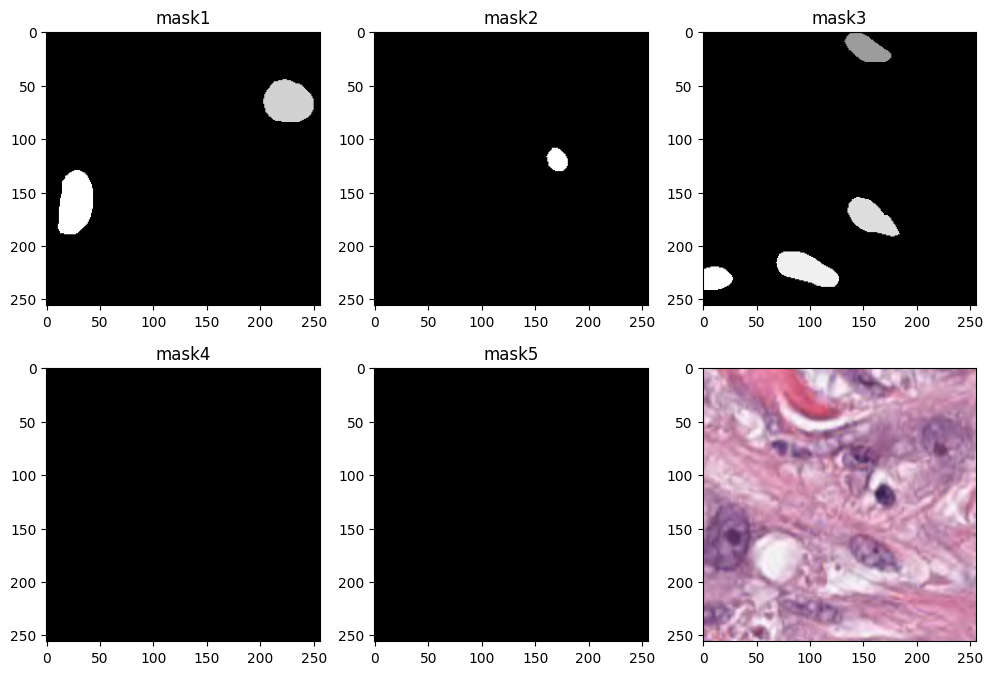

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
for i in range(5):#six data last one is flag, so we only need 0,1,2,3,4
    axes[i].imshow(masks_1[5][:,:,i],cmap='gray')
    axes[i].set_title('mask'+str(i+1))
axes[5]=plt.imshow(image_1_32[5])

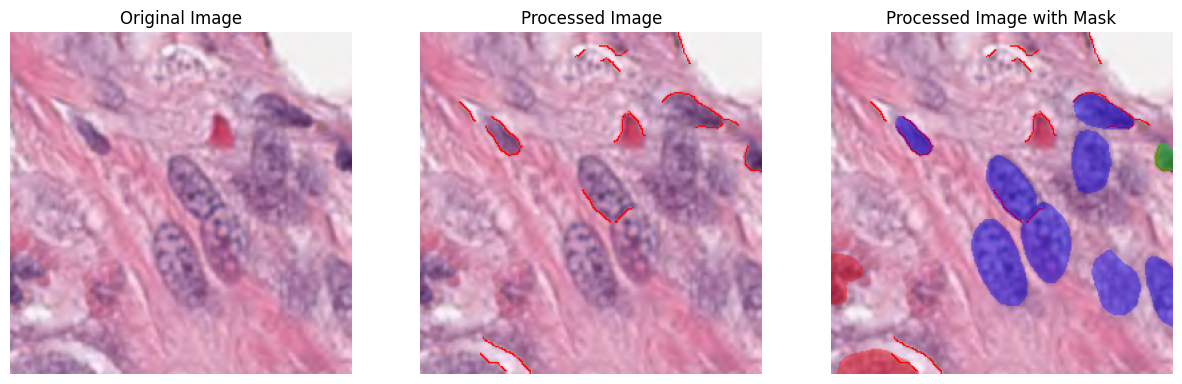

In [12]:
maks_process_and_show(8)

In [13]:
mask_2d = convert_3d_mask_to_2d_vectorized(masks_1) - 1
images =  np.uint8(image_1)#process_gaussian_K_vectorized(image_1)#

In [14]:
print(mask_2d.shape)
print(images.shape)

(985, 256, 256)
(985, 256, 256, 3)


In [15]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np

class DroneDataset(Dataset):
    
    def __init__(self, images, masks, mean, std, transform=None, patch=False):
        """
        Initialize the dataset.
        :param images: Numpy array of images.
        :param masks: Numpy array of masks.
        :param mean: Mean for normalization.
        :param std: Standard deviation for normalization.
        :param transform: Optional transformation to apply.
        :param patch: Whether to generate patches from images.
        """
        self.images = images
        self.masks = masks
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)

        # Apply standard transformations
        
        t = T.Compose([T.ToTensor()])
       
        
        #img =  T.functional.equalize(img)
        img = t(img)
        
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        """
        Generate patches from the image and mask.
        :param img: Image tensor.
        :param mask: Mask tensor.
        :return: Patches of the image and mask.
        """
        
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)


        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

Batch 1
torch.Size([3, 256, 256])


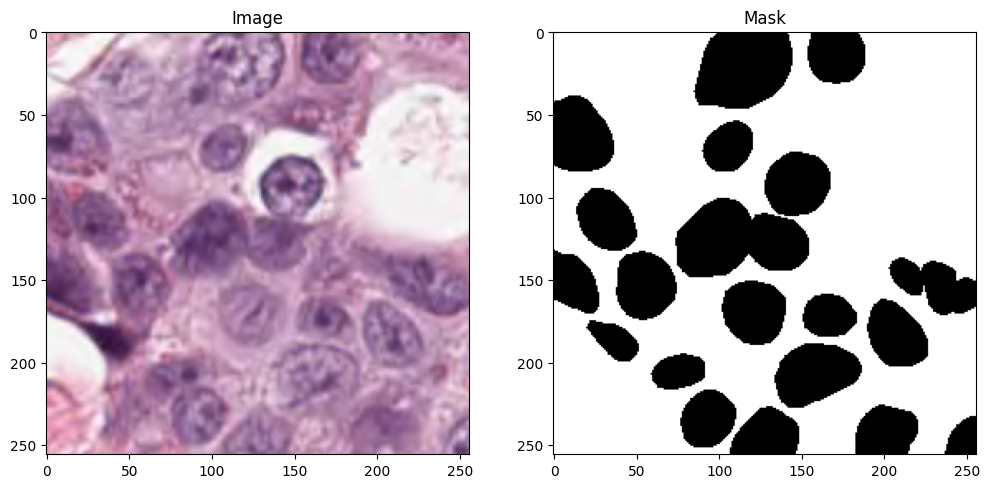

In [16]:
import albumentations as A
import cv2

t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.RandomCrop(680, 1032),  # Random crop
    A.PadIfNeeded(min_height=704, min_width=1056, border_mode=cv2.BORDER_CONSTANT, value=0),  # Pad the image back to (704, 1056)
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=30),  # Random rotation
    A.ElasticTransform(alpha=1, sigma=50),  # Elastic transform
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),  # Random contrast and brightness
    A.RandomGamma(gamma_limit=(80, 120)),  # Random gamma
    A.CLAHE(clip_limit=4.0, p=0.7),  # CLAHE
    A.GridDistortion(p=0.2),
    A.GaussNoise()
], is_check_shapes=False)

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
], is_check_shapes=False)



t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
], is_check_shapes=False)


dataset = DroneDataset(images, mask_2d, mean=[0.4, 0.27, 0.57], std=[0.4131182, 0.3946274, 0.4131182])

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Function to display images and masks
def show(img, mask):
    np_img = img.numpy().transpose((1, 2, 0))
    #np_img = process_guassain(np_img,9)
    np_mask = mask.numpy()
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(np_img)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(np_mask, cmap='gray')
    plt.title('Mask')
    plt.show()
    
# Iterate over the DataLoader
for i, (img, mask) in enumerate(dataloader):
    print(f"Batch {i+1}")
    # Display the first image and mask in the batch
    print(img[0].shape)
    show(img[0], mask[0])

    # For demonstration, only show the first batch
    if i == 0:
        break
    break